# Malaria detection with CNN

We are going to train a model to classify malaria-infected cells from those without, via the use of a CNN.
Data available at https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria

## Load dependencies

In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
print(os.listdir("C:/Users/mifab/Documents/Git/Python_DS_Projects/CompVis/cell_images/cell_images"))

['Parasitized', 'Uninfected']


## Read Images

In [71]:
infected = os.listdir('C:/Users/mifab/Documents/Git/Python_DS_Projects/CompVis/cell_images/cell_images/Parasitized') 
uninfected = os.listdir('C:/Users/mifab/Documents/Git/Python_DS_Projects/CompVis/cell_images/cell_images/Uninfected/')

In [72]:
data = []
labels = []

for i in infected:
    try:
    
        image = cv2.imread("C:/Users/mifab/Documents/Git/Python_DS_Projects/CompVis/cell_images/cell_images/Parasitized/"+i)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((64 , 64))
        data.append(np.array(resize_img))
        labels.append(1)
        
    except AttributeError:
        print('e')
    
for u in uninfected:
    try:
        
        image = cv2.imread("C:/Users/mifab/Documents/Git/Python_DS_Projects/CompVis/cell_images/cell_images/Uninfected/"+u)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((64 , 64))
        data.append(np.array(resize_img))
        labels.append(0)
        
    except AttributeError:
        print('b')

e
b


In [73]:
cells = np.array(data)
labels = np.array(labels)

np.save('Cells' , cells)
np.save('Labels' , labels)

In [74]:
print('Cells : {} | labels : {}'.format(cells.shape , labels.shape))


Cells : (27558, 64, 64, 3) | labels : (27558,)


# EDA

## Visualize sub-set

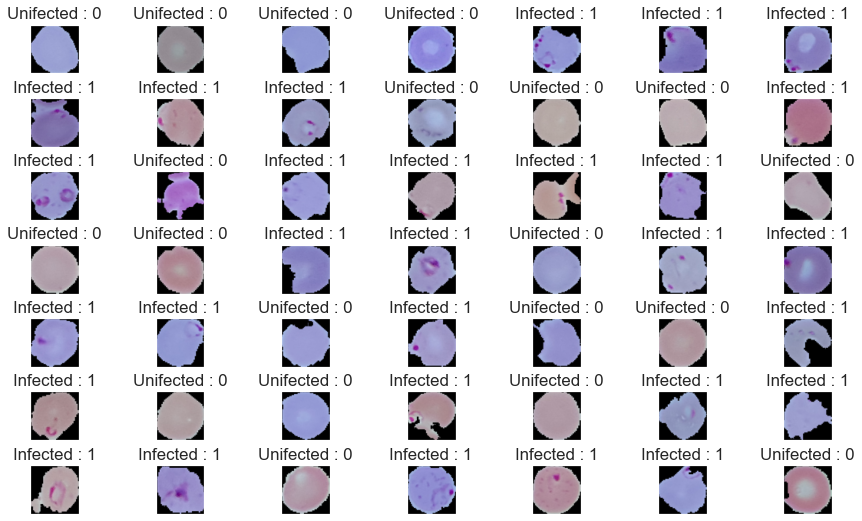

In [75]:
plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint(0 , cells.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(cells[r[0]])
    plt.title('{} : {}'.format('Infected' if labels[r[0]] == 1 else 'Unifected' ,
                               labels[r[0]]) )
    plt.xticks([]) , plt.yticks([])
    
plt.show()

We can obsrve the purple tinted spots in the infected cells, absent from healthy ones.
Shape seems inconsistent as marker, but slightly more round in uninfected.

In [76]:
n = np.arange(cells.shape[0])
np.random.shuffle(n)
cells = cells[n]
labels = labels[n]

In [77]:
cells = cells.astype(np.float32)
labels = labels.astype(np.int32)
cells = cells/255

## Plot mean per Class

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


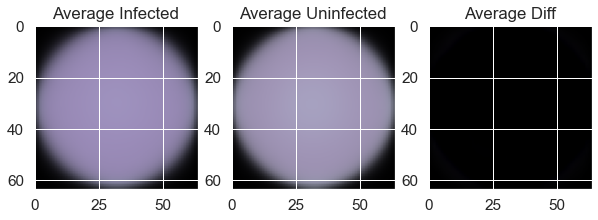

In [78]:
mean_inf=np.mean(cells[labels.astype(bool),:,:],0)
mean_un_inf=np.mean(cells[np.invert(labels.astype(bool)),:,:],0)
diff=mean_inf-mean_un_inf

fig = plt.figure(figsize=(10, 30))
ax=fig.add_subplot(1,3,1)
ax.imshow(mean_inf)
plt.title('Average Infected')

ax2=fig.add_subplot(1,3,2)
ax2.imshow(mean_un_inf)
plt.title('Average Uninfected')

ax3=fig.add_subplot(1,3,3)
ax3.imshow(diff)
plt.title('Average Diff')
plt.show()

We see that the average per class are very similar, as pots are not located in specific areas of the cell.

## See Class Proportion

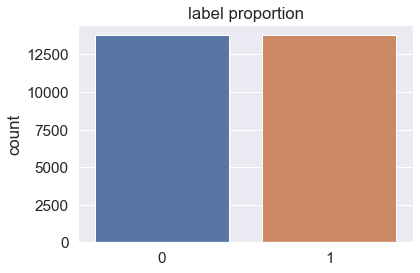

In [79]:
plt.figure(1)
sns.countplot(x = labels)
plt.title('label proportion')
plt.show()

Class proportions are 50/50, no need to augment or subsample one over the other before training.

# TRAIN MODEL

## Split to train/eval/test at 80/10/10

In [95]:
from sklearn.model_selection import train_test_split

train_x , x , train_y , y = train_test_split(cells , labels , 
                                            test_size = 0.2 ,
                                            random_state = 111)

eval_x , test_x , eval_y , test_y = train_test_split(x , y , 
                                                    test_size = 0.5 , 
                                                    random_state = 111)
print('train data shape {} ,eval data shape {} , test data shape {}'.format(train_x.shape,
                                                                           eval_x.shape ,
                                                                           test_x.shape))

train data shape (22046, 64, 64, 3) ,eval data shape (2756, 64, 64, 3) , test data shape (2756, 64, 64, 3)


## Augment for training

In [97]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_aug = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,  
    zoom_range=0.2,        
    horizontal_flip=True,
    vertical_flip=True)  

val_aug= ImageDataGenerator(
    rescale=1./255)

train_gen = train_aug.flow(
    train_x,
    train_y,
    batch_size=16)

val_gen = val_aug.flow(
    eval_x,
    eval_y,
    batch_size=16)

## Define Model

In [1]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.activations import *
from tensorflow.keras.metrics import *

def classifier(input_size=(64,64,3)):
    inputs = Input(input_size)
    conv1= Conv2D(16, (3,3), activation='relu', padding="same")(inputs)
    bn1=BatchNormalization()(conv1)
    pool1=MaxPool2D(pool_size=(3,3))(bn1)
    
    conv2= Conv2D(32, (3,3), activation='relu', padding="same")(pool1)
    bn2=BatchNormalization()(conv2)
    pool2=MaxPool2D(pool_size=(3,3))(bn2)
    
    conv3= Conv2D(64, (3,3), activation='relu', padding="same")(pool2)
    bn3=BatchNormalization()(conv3)
    
    conv4= Conv2D(64, (3,3), activation='relu', padding="same")(bn3)
    bn4=BatchNormalization()(conv4)
    
    conv5= Conv2D(128, (3,3), activation='relu', padding="same")(bn4)
    bn5=BatchNormalization()(conv5)
    pool3=MaxPool2D(pool_size=(3,3))(bn5)

    f=Flatten()(pool3)
    d1=Dense(512, activation='relu')(f)
    do1=Dropout(0.5)(d1)
    d2=Dense(512, activation='relu')(do1)
    do2=Dropout(0.5)(d2)
    d3=Dense(2, activation='softmax')(do2)

    return Model(inputs=[inputs], outputs=[d3])

In [2]:
model = classifier(input_size=(64,64,3))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [3]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 21, 21, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0     

In [111]:
tf.test.gpu_device_name()


'/device:GPU:0'

## Set training parameters and Train

In [112]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    save_freq="epoch"
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=7,
    verbose=2,
    mode='min'
)
reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=40,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,earlystop,reduce]

In [113]:
history = model.fit(
        train_gen,
        epochs=10,
        validation_data=val_gen,
        verbose = 1,
        callbacks=callbacks
        )

Epoch 1/10
1378/1378 [==============================] - 18s 12ms/step - loss: 0.4040 - acc: 0.8499 - val_loss: 0.1875 - val_acc: 0.9296

Epoch 00001: val_loss improved from inf to 0.18749, saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets
Epoch 2/10
1378/1378 [==============================] - 18s 13ms/step - loss: 0.1990 - acc: 0.9389 - val_loss: 0.1550 - val_acc: 0.9561

Epoch 00002: val_loss improved from 0.18749 to 0.15497, saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets
Epoch 3/10
1378/1378 [==============================] - 16s 12ms/step - loss: 0.2002 - acc: 0.9419 - val_loss: 0.1734 - val_acc: 0.9510

Epoch 00003: val_loss did not improve from 0.15497
Epoch 4/10
1378/1378 [==============================] - 17s 13ms/step - loss: 0.1973 - acc: 0.9420 - val_loss: 0.2200 - val_acc: 0.9608

Epoch 00004: val_loss did not improve from 0.15497
Epoch 5/10
1378/1378 [==============================] - 17s 12ms/step - lo

In [114]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

173/173 [==============================] - 0s 2ms/step - loss: 0.1147 - acc: 0.9608
Model Test Loss: 0.11473905295133591
Model Test Accuracy: 0.9608127474784851


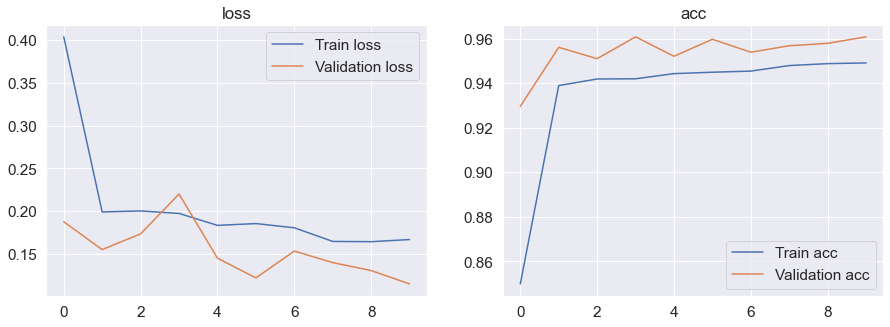

In [115]:
show_final_history(history)
model.load_weights(best_model_weights)
model_score = model.evaluate(val_gen)
print("Model Test Loss:",model_score[0])
print("Model Test Accuracy:",model_score[1])


The model converged with few epochs.
It appears to have fitted well, no under or overfitting is visible.

## Evaluate test set

In [118]:
preds = model.predict(test_x)
preds = np.argmax(preds, axis=-1)

print(test_y.shape)
print(preds.shape)

print(np.unique(orig_test_labels))
print(np.unique(preds))

(2756,)
(2756,)
[2]
[0 1]


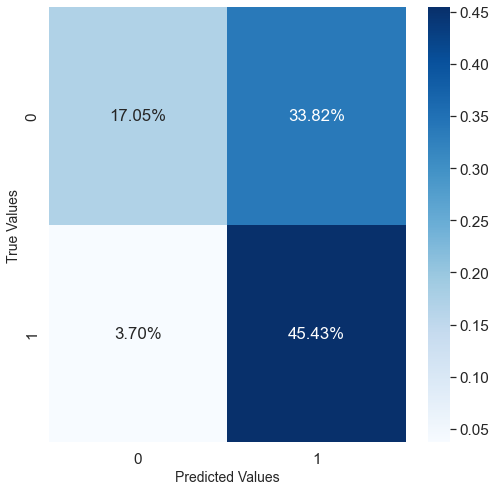

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, preds)
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(1,1,1)
sns.set(font_scale=1.4) #for label size
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')
ax1.set_ylabel('True Values',fontsize=14)
ax1.set_xlabel('Predicted Values',fontsize=14)
plt.show()

# Conclusions

It is possible to train a CNN to classify cells for malaria detection.
The performance of the model can be improved, as shown by the test set evaluation matrix,
which showed a bias torwards the infected label, when the dataset was balanced.
A solution can be more augmentation, trying a different architecture, and changing the learning parameters.